******************
# 1. ***`DATA IMPORT AND SETUP`***
******************

## 1a. Setting up CoLab and Libraries

In [12]:
#Checking RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

ModuleNotFoundError: No module named 'psutil'

In [2]:
from google.colab import drive

In [ ]:
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

In [4]:
#intended path is  </content/drive/My Drive/Colab Notebooks/CLTC_Notebook_Data>
%pwd

In [5]:
%cd /content/drive/My Drive/Colab Notebooks/CLTC_Notebook_Data

/content/drive/My Drive/Colab Notebooks/CLTC_Notebook_Data


In [ ]:
!pip install tldextract
!pip install pycountry
!pip install jupyterthemes

In [13]:
import pandas as pd
import os
import re
import tldextract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import os, time, http.client
from termcolor import colored
import sys
import json
from pygments import highlight, lexers, formatters
import pycountry
import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import statistics

In [14]:
# Tools for visualizing the data

# requires jupytertehmes

%pylab inline
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
jtplot.reset()

Populating the interactive namespace from numpy and matplotlib


## 1b. Importing and Cleaning Data

In [ ]:
#iclabcombined = pd.read_csv("combined.csv", dtype={'country' : str})

Dropping the columns which were meant for internal use of ICLAB team and the header columns which have come into dataset via join

In [ ]:
# iclabcombined.drop(['filename', 'as_number'], axis=1, inplace= True)

# iclabcombined.drop([ 3078134,  4235577, 12411076, 18967078, 25041685, 26600938,
#             28192530, 29460039, 30795516, 32569776, 34391850, 36093972,
#             37793956, 39298313, 40934970, 42276914, 42976448, 44455181,
#             47068048, 49383978], inplace = True)

Correcting wrongly coded boolean values in the datasets

In [ ]:
# iclabcombined['dns'].replace('false',False,inplace=True)
# iclabcombined['dns_all'].replace('false',False,inplace=True)
# iclabcombined['block'].replace('false',False,inplace=True)
# iclabcombined['packet_updated'].replace('false',False,inplace=True)
# iclabcombined['censored_updated'].replace('false',False,inplace=True)

# iclabcombined['dns'].replace('true',True,inplace=True)
# iclabcombined['dns_all'].replace('true',True,inplace=True)
# iclabcombined['block'].replace('true',True,inplace=True)
# iclabcombined['packet_updated'].replace('true',True,inplace=True)
# iclabcombined['censored_updated'].replace('true',True,inplace=True)

## 1c. Importing categories

In [ ]:
# catDF = pd.read_fwf('type_domain_mapping.txt',header=None, names=[ "Name"], sep="")

In [ ]:
# catDF = catDF.Name.apply(lambda x: pd.Series(str(x).split("|||"))).rename(columns={0:'category',1:'site'})

In [ ]:
# allCategories = set(catDF['category'])
# len(allCategories)

In [ ]:
# ADDING CATEGORY AS A PERMANENT COLUMN

# urlListAll = iclabcombined['url'].tolist()
# sitesListAll = []

# for item in urlListAll:
#     domainAll = tldextract.extract(item)[1]
#     suffixAll = tldextract.extract(item)[2]
#     sitesListAll.append(domainAll + "." + suffixAll)

In [ ]:
# iclabcombined['site'] = sitesListAll
# iclabcombined = pd.merge(iclabcombined, catDF, on='site',how='left')

In [ ]:
#iclabcombined['category'] = iclabcombined['category'].fillna(0)
#iclabcombined['category']=iclabcombined['category'].replace(0,'Undefined')

In [ ]:
#iclabcombined.head()

In [ ]:
# PICKLING OUR DATA FOR FASTER ACCESS
#iclabcombined.to_pickle('iclabcombined.pkl')

## 1d. Accessing DataFrame (H5/Pickle)

In [ ]:
iclabcombined = pd.read_pickle('iclabcombined.pkl')
#iclabcombined.to_hdf('iclabcombined.h5', key='iclabcombined', mode='w')
#iclabcombined = pd.read_hdf('iclabcombined.h5', key='iclabcombined',mode='r')

In [ ]:
print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))

The number of observations in our original data set are 50436846 and the number of features/columns are 17 


In [ ]:
iclabcombined.sample(5)

,server_t,country,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site,category
47636114,2018-08-07T22:03:55.671Z,US,citizenlab-global,http://indeed.com/,False,NaN,False,NaN,200,False,47445,{},NaN,NaN,False,indeed.com,Job Search
18556492,2017-04-28T20:25:16.240Z,US,citizenlab-global,http://kaskus.co.id/,NaN,NaN,-2,no_control_resp,200,False,107401,{},NaN,NaN,False,kaskus.co.id,Newsgroups and Message Boards
7700181,2017-03-15T23:58:32.190Z,AU,citizenlab-global,http://www.iucn.org/,False,sameip,False,NaN,-1,False,0,{},NaN,NaN,False,iucn.org,Undefined
13640476,2017-04-05T14:00:27.092Z,US,citizenlab-global,http://emol.com/,NaN,NaN,NaN,NaN,200,False,130051,{},NaN,NaN,False,emol.com,News and Media
13428836,2017-04-04T17:59:22.555Z,US,citizenlab-global,http://force.com/,-2,no_control_resp,False,NaN,200,False,197170,{},NaN,NaN,False,force.com,Information Technology


IN THE LATEST ITERATION OF THIS NOTEBOOK (07/17) NO DATA FOR "USA" HAS BEEN DROPPED 

******************
# 2. ***`ANALYZING FALSE POSITIVES`*** 
******************

*(Redundant section as of 07/2020)*

In [ ]:
# #function to find blocked URLs
# def blockedURLs(cc):
#     return (set(iclabcombined[ (iclabcombined['country']== cc)& ((iclabcombined['censored_updated']==True)) ]['url']))

## 2a. Looking at sites which only have censored_updated = True

The below query produces 167 urls, these are the URLs for which the ICLab team believes the packets might have been injected i.e. becuase there was a response after RST or FIN or maybe because of ICMP admin prohibited i.e. they determined there's a firewall that blocks a connection. Removing these from our data as these are cases of PROBABLE CENSORSHIP and not ACTUAL censorship

In [ ]:
#( set(iclabcombined[ (iclabcombined['country']=='US')  & ((iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['packet_updated']== True))]['url']))

Even urls for which a 4xx or 5xx result was returned are accessible and some of them are URLS commonly accessed in US

In [ ]:
# set(iclabcombined
#     [ (iclabcombined['country']=='US') 
#                    & 
#      (
#          (iclabcombined['http_status']== 403.0) | (iclabcombined['http_status']== 404.0) | (iclabcombined['http_status']== 504.0)
#      )
#      &
#      (   
#                        (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False)
#                        & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) 
#                        & (iclabcombined['packet_updated']== True)
#                    )]
#      ['url'])

In [ ]:
#httpError = np.arange(400,600,1,dtype=float)

The falsePositIndex here are the sites which return a http 200 and only show packet_updated = True. In below query, I eliminate the countries where the result of HTTP was not a 400/500 errorand the only mechanism of censorship was that the packet_updated = True i.e. all these are probable censorships

In [ ]:
# falsePositIndex = iclabcombined[
#     (~iclabcombined.http_status.isin(httpError))  
#                    & (   (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['packet_updated']== True)
#                      )] [['country','url','http_status']].index.tolist()

In [ ]:
# print("We have " + str(len(falsePositIndex)) + " probable censoriships which could be false positives")

In [ ]:
# iclabcombined.drop(falsePositIndex,inplace=True)

Now having a look at FALSE NEGATIVES
We define false negatives as websites which are showing censored_updated = False here but upon testing actually are inaccessible

In [ ]:
# set(iclabcombined[(iclabcombined['country']=='US')&(iclabcombined['censored_updated']==False) & (iclabcombined.http_status.isin([403.0]))]['url'])

In total as seen below we have 3389 websites which show up as not censored in US but the corresponding HTTP results are error codes, manual testing of these websites show that they are accessible, its not possible to actually determine the status of all false negatives. Based on our testing and seeing that they are not marked as blocked eventually and also because we believe that false negatives are not too critical to our project  $hence$ $we$ $wont$ $drop$ $them$ $from$ $the$ $data$ $set$

## 2b. Removing the FALSE POSITIVIES (US blocked sites) from our main dataset iclabcombined

From this data looking at the sites that are shown as censored in US. THESE SITES HAVE CENSORED = TRUE AND RETURN A HTTP ERROR

In [ ]:
#set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_status.isin(httpError) & ( (iclabcombined['dns_all']== True) | (iclabcombined['block']== True)|(iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True)))]['url'])

In [ ]:
# SITES SHOWING HTTP status reason as block in US but still accessible
#set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_reason.str.contains('block'))]['url'])

Overall all the above results show a very dirty data, we basically removed the root urls of all the sites that show 404 in US and then checked how many of them are accesible. There are no patterns while some are showing as blocked on testing others are not. BELOW WE REMOVE THESE FALSE POSITIVIES FROM THE US

In [ ]:
#USFPlist = (iclabcombined [(iclabcombined['country']=='US') & (iclabcombined['censored_updated'] == True)]['site']).unique().tolist()

In [ ]:
#USblockIclab = len(iclabcombined[iclabcombined['site'].isin(USFPlist)])

In [ ]:
# print("There are {} unique blocked websites in the US".format(len(USFPlist)))
# print("There are {} total observations of these blocked websites throughout our dataset".format(USblockIclab))

In [ ]:
# USFPIndex is the index of all those observations for the unique sites which are blocked in US and we are going to remove from the entire DB
#USFPIndex = iclabcombined[iclabcombined['site'].isin(USFPlist)].index

In [ ]:
#iclabCLEAN = iclabcombined.drop(USFPIndex)

iclabCLEAN is our cleaned dataframe

## 2c. PICKLING OUR CLEAN DATASET FOR FASTER ACCESS

In [ ]:
#iclabCLEAN.to_pickle('iclabCLEAN.pkl')

In [ ]:
# LOADING DATA FRAME FROM PICKLE
#iclabCLEAN = pd.read_pickle('iclabCLEAN.pkl')

In [ ]:
# COMPARNING DATA SIZES of RAW and CLEAN DATA 
#print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))
#print("The number of observations in our CLEANED data set i.e. without sites blocked in USA are {0} and the number of features/columns are {1} ".format(iclabCLEAN.shape[0],iclabCLEAN.shape[1]))

$******************************************************************$

******************
# 3.  ***`RUNNING EXPERIMENTS`***
******************

## 3a. Experiment 1

Looking at the exact webpages blocked

In [ ]:
# blockpageTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
# len(blockpageTR)

In [ ]:
# blockpageRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
# len(blockpageRU)

In [ ]:
# RUblockpageTR = blockpageTR.intersection(blockpageRU)
# RUblockpageTR

## 3b. Experiment 2

Most captured categories in our dataset

In [ ]:
iclabcombined[iclabcombined['censored_updated']==True].groupby('category').count().sort_values(by='site',ascending=False).head(10)

In [ ]:
# blockIN = set(iclabCLEAN[(iclabCLEAN['country']=='IN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockIN)

In [ ]:
# blockCN = set(iclabCLEAN[(iclabCLEAN['country']=='CN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockCN)

In [ ]:
# blockVN = set(iclabCLEAN[(iclabCLEAN['country']=='VN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockVN)

In [ ]:
# blockRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True)| (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True))]['site'])
# len(blockRU)

In [ ]:
# blockTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['site'])
# len(blockTR)

In [ ]:
# blockNL = set(iclabCLEAN[(iclabCLEAN['country']=='NL') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockNL)

In [ ]:
# blockNZ = set(iclabCLEAN[(iclabCLEAN['country']=='NZ') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockNZ)

In [ ]:
# AU_NZ = blockNZ.intersection(blockAU)
# len(AU_NZ)

In [ ]:
# blockMX = set(iclabCLEAN[(iclabCLEAN['country']=='MX') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockMX)

In [ ]:
# IN_RU = blockIN.intersection(blockRU)
# (IN_RU)

Intersections as per EXPERIMENT 2

In [ ]:
# RU_TR = blockRU.intersection(blockTR)

In [ ]:
# BR_MX = blockMX.intersection(blockBR)

In [ ]:
# NL_TR = blockNL.intersection(blockTR)

As part of Experiment 2 : 
(a) A look at censored FB Pages in India

Looking at worldwide distribution of FB blocking

In [ ]:
# iclabCLEAN[iclabCLEAN['url'].str.contains('facebook')].groupby('country').count()

Looking at FB pages censored in India

In [ ]:
# fbIndBlock = set (iclabcombined [ ( (iclabcombined['block']== True) | (iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True) ) & (iclabcombined['url'].str.contains('facebook')) & (iclabcombined['country']=='IN') ]['url'])
# fbIndBlock

(b) A look into religious censorship in the world

In [ ]:
# iclabCLEAN[ (iclabCLEAN['category'].isin(['Global Religion','Alternative Beliefs'])) & ( (iclabCLEAN['block']== True) | (iclabCLEAN['censored_updated'] == True) ) ].groupby(['country', 'site']).first()

## 3c. Experiment 3 (Important)
*Defining a function which computes contribution of each category in a countries blocked sites*

In [ ]:
def Category_contributions(cc):
    catDataCC = iclabcombined[(iclabcombined['country']==cc) & (iclabcombined['censored_updated']==True) ]
    catDataCC= catDataCC.drop(['server_t', 'censored_updated','site','dns_all','packet_reason','url','dns','dns_reason','dns_reason_all','schedule_name','http_status','block','body_len','http_reason','packet_updated'], axis=1)
    catDataCC = catDataCC.groupby('category').count()
    catDataCC['%Cat'] = (catDataCC['country']*100)/(catDataCC['country'].sum())
    catDataCC= catDataCC.reset_index().drop('country',axis=1)
    catDataCC= catDataCC.rename(columns={'country':'Number of sites in' + str(cc),'%Cat':cc})
    return catDataCC

In [ ]:
#Category_contributions('US')
#Category_contributions('CA')

In [ ]:
# INplot = Category_contributions('IN')
# display(INplot)
# TRplot =Category_contributions('TR')
# RUplot = Category_contributions('RU')
# KRplot= Category_contributions('KR')
# USplot = Category_contributions('US')
# CNplot = Category_contributions('CN')
# CAplot  = Category_contributions('CA')
# ZAplot  = Category_contributions('ZA')

 Plotting the graph below:

In [ ]:
# graphcompare1 = pd.merge(INplot,TRplot, on='category', how='outer')
# graphcompare2 = pd.merge(graphcompare1,KRplot, on='category', how='outer')
# graphcompare3 = pd.merge(graphcompare2,RUplot, on='category', how='outer')
# graphcompare4 = pd.merge(graphcompare3,USplot, on='category', how='outer')
# graphcompare5 = pd.merge(graphcompare4,CNplot, on='category', how='outer')

In [ ]:
# # set width of bar
# barWidth = 0.15
 
# # set height of bar
# TR = graphcompare3['TR']
# RU = graphcompare3['RU']
# IN = graphcompare3['IN']
# KR = graphcompare3['KR']
 
# # Set position of bar on X axis
# r1 = np.arange(len(TR))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
# r4 = [x + barWidth for x in r3]
 
# # Make the plot
# plt.figure(figsize = (20,12))
# plt.bar(r1, TR, color='green', width=barWidth, edgecolor='dimgrey', label='Turkey')
# plt.bar(r2, RU, color='red', width=barWidth ,  edgecolor='dimgrey',label='RU')
# plt.bar(r3, IN, color='blue', width=barWidth,  edgecolor='dimgrey',label='India')
# plt.bar(r4, KR, color='darkorange', width=barWidth,  edgecolor= 'dimgrey',label='South Korea') 

# # Add xticks on the middle of the group bars
# plt.ylabel("Percentage", size=15)
# plt.ylim(0,100)
# plt.xticks([r for r in range(len(TR))], graphcompare3['category'].tolist() ,rotation=-90, size=16)

# # Create legend & Show graphic
# plt.legend(loc = 'upper left', fontsize = 15)
# plt.title("\n Category-wise blocking in countries \n", size = 15)
# plt.show()

Showing a few sample metrics

In [ ]:
# graphcompare5.fillna(0,inplace=True)

# KRvals = graphcompare5['KR']
# RUvals = graphcompare5['RU']
# INvals = graphcompare5['IN']
# TRvals = graphcompare5['TR']

In [ ]:
# KRsimilarityRU = (1 - spatial.distance.cosine(KRvals, RUvals))*100
# print(KRsimilarityRU)

# INsimilarityTR = (1 - spatial.distance.cosine(INvals, TRvals))*100
# print(INsimilarityTR)

# INsimilarityKR = (1 - spatial.distance.cosine(INvals, KRvals))*100
# print(INsimilarityKR)

# INsimilarityRU = (1 - spatial.distance.cosine(INvals, RUvals))*100
# print(INsimilarityRU)

# KRsimilarityTR = (1 - spatial.distance.cosine(KRvals, TRvals))*100
# print(KRsimilarityTR)

# RUsimilarityTR = (1 - spatial.distance.cosine(RUvals, TRvals))*100
# print(RUsimilarityTR)

******************
# 4. ***`SIMILARITY METRIC DF FOR ALL COUNTRIES`***
******************

## 4a. Proxy 1

In [ ]:
allCountries = (iclabcombined['country'].unique())
print("The total countries we have in our clean dataset are {}".format(len(allCountries)))

The total countries we have in our clean dataset are 55


In [ ]:
allCategories = (iclabcombined['category'].unique())
print("The total unique categories we have in our clean dataset are {}".format(len(allCategories)))

The total unique categories we have in our clean dataset are 73


In [ ]:
simMetricDF = pd.DataFrame(index = allCategories, columns=None)

In [ ]:
simMetricDF['dummy']= pd.Series(np.zeros(len(simMetricDF)))
simMetricDF.reset_index(inplace=True)
simMetricDF.rename(columns={'index':'category'},inplace=True)
simMetricDF.head()

,category,dummy
0,File Sharing and Storage,NaN
1,Reference,NaN
2,Information Technology,NaN
3,Instant Messaging,NaN
4,News and Media,NaN


In [ ]:
for country in allCountries:
    simMetricDF = pd.merge(simMetricDF,Category_contributions(country), on= 'category', how='outer')

In [ ]:
simMetricDF.set_index('category',inplace = True)

In [ ]:
#REPLACING NaN's with 0
simMetricDF.fillna(0,inplace=True)

In [ ]:
simMetricDF.drop("dummy",axis=1,inplace = True)

In [ ]:
simMetricDF.head()

In [ ]:
countryList =  allCountries.tolist()
numCatBlock = []

In [ ]:
for item in countryList:
    numCatBlock.append(len(simMetricDF[simMetricDF[item]!=0]))

In [ ]:
tempDF = pd.DataFrame(index=countryList)
tempDF['numCatBlock'] =numCatBlock
tempDF = tempDF.sort_values(by='numCatBlock',ascending = False)

In [ ]:
#Getting all columns i.e. countries
simCols=[]
for i in range(len(simMetricDF.columns)):
    simCols.append(simMetricDF.columns[i])
print("We have {} unique countries".format(len(simCols)))

We have 55 unique countries


In [ ]:
#Creating pairs to do calculation of spatial distance
from itertools import combinations
pairs = [comb for comb in sorted(combinations(simCols, 2))]
print("We have {} unique pairs from these countries including dummy".format(len(pairs)))

We have 1485 unique pairs from these countries including dummy


In [ ]:
#Both vectors are non zeroes
print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['AU'], simMetricDF['IN']))))

# When even one vector is completeley a zero vector
print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['US'], simMetricDF['IN']))))

 **** Similarity is 0.4828392733242386 ****
 **** Similarity is 0.4783742057862431 ****


In [ ]:
#NewSimVal will store the similarity value calculated from the spatial cosine distance formula

NewSimVals = []
for item in pairs:
    if (np.sum(simMetricDF[item[0]]) == 0) & (np.sum(simMetricDF[item[1]]) ==0):
        NewSimVals.append((item,1))
    elif (np.sum(simMetricDF[item[0]]) == 0) | (np.sum(simMetricDF[item[1]]) ==0):
        NewSimVals.append((item,0))
    else :
        NewSimVals.append((item,(1 - spatial.distance.cosine(simMetricDF[item[0]], simMetricDF[item[1]]))))

In [ ]:
simMetricVals = pd.DataFrame(index=pairs, columns = None )
simMetricVals['similarity'] = [j for (i,j) in NewSimVals]
simMetricVals.reset_index(inplace=True)
simMetricVals.rename(columns={'index':'pair'},inplace=True)
simMetricVals[['country_code_alpha2_A', 'country_code_alpha2_B']] = pd.DataFrame(simMetricVals['pair'].tolist(), index=simMetricVals.index)
simMetricVals = simMetricVals[['pair','country_code_alpha2_A','country_code_alpha2_B','similarity']]
simMetricVals.head()

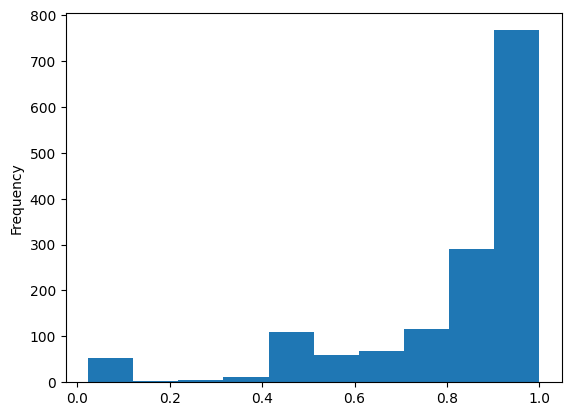

In [ ]:
simMetricVals['similarity'].plot.hist()
plt.show()

In [ ]:
# #Pickling the simMetricVals data set
#simMetricVals.to_pickle("simMetricVals.pkl")

## 4b. Proxy 2: Proportion of blocking events

While our first metric (above) gives us a good sense of blocking overlaps,
it fails to show us variation in the *volume* of blocking. Some countries have more blocking than others. We want to account for that.

We'll measure the volume of blocking in each country. We'll do that by measuring, for each country, the *proportion* of observations where `censored=True`.

Reading simMetricVals from pickle



In [ ]:
simMetricVals = pd.read_pickle("simMetricVals.pkl")

**Calculating for number of sites blocked in each country**

In [ ]:
NumSitesBlocked = iclabcombined.loc[(iclabcombined['censored_updated']==True),['site','country']].sort_values(by='country',ascending = False)

In [ ]:
total_observations_by_country = iclabcombined.groupby('country').count()

In [ ]:
total_blocked_observations_by_country = iclabcombined[iclabcombined['censored_updated']==True].groupby('country').count()

In [ ]:
dummy_column_for_counting = 'dns'

def as_single_column (df):
    return df[[dummy_column_for_counting]]

def proportion (row):
    blocked = row[dummy_column_for_counting+'_blocked']
    total = row[dummy_column_for_counting+'_total']
    return blocked / total


blocking_proporitons =\
as_single_column(total_blocked_observations_by_country)\
    .merge(as_single_column(total_observations_by_country),
           on='country', suffixes=('_blocked', '_total'))\
    .apply(proportion, axis=1)

blocking_proporitons

Now we can compute the similarity in proportions between two countries.

In [ ]:
def get_proportion (cc2):
    # try to retrieve it
    try:
        return blocking_proporitons[cc2]
    # if we don't have data on it
    except KeyError:
        # treat it as 0
        return 0

def compute_similarity(proportion1, proportion2):
    # keep it simple....
    # minimum and maximum values will still be 0 and 1, since we're dealing with proportions.
    return 1 - abs(proportion1 - proportion2)

CountSimilarity = []
for item in pairs:
    (country1, country2) = item
    similarity = compute_similarity(get_proportion(country1), get_proportion(country2))
    CountSimilarity.append((item, similarity))

In [ ]:
blocking_proportion_similarities =\
pd.DataFrame(CountSimilarity, columns=[
    'pair',
    'proportion-similarity'
])
blocking_proportion_similarities

,pair,proportion-similarity
0,"(AD, AT)",0.999027
1,"(AD, BE)",0.999367
2,"(AD, BR)",0.998432
3,"(AD, CA)",0.999622
4,"(AD, CR)",NaN
...,...,...
1480,"(ZA, SG)",0.999872
1481,"(ZA, SK)",0.999836
1482,"(ZA, TR)",0.978623
1483,"(ZA, TW)",0.997475


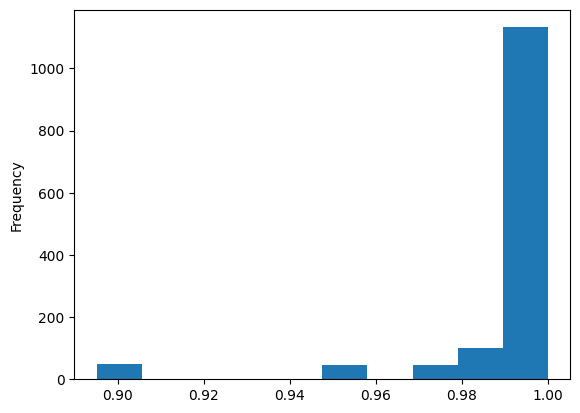

In [ ]:
blocking_proportion_similarities['proportion-similarity'].plot.hist()
plt.show()

Not much variation here. That's okay. We'll just min-max normalize it.

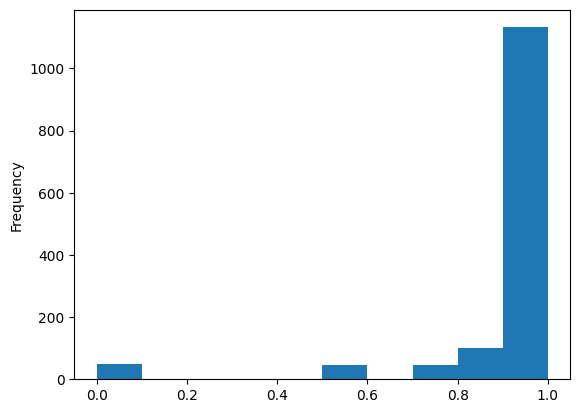

In [ ]:
def min_max_norm(series):
    return (series-series.min())/(series.max()-series.min())

blocking_proportion_similarities['proportion-similarity-normalized'] = \
    min_max_norm(blocking_proportion_similarities['proportion-similarity'])
blocking_proportion_similarities['proportion-similarity-normalized'].plot.hist()

plt.show()

## 4c. Merging these two

In [ ]:
MetricDF = pd.merge(simMetricVals,blocking_proportion_similarities,on='pair',how='outer')
MetricDF = MetricDF.rename(columns={
    'similarity':'Censored_Category_Similarity',
    'proportion-similarity-normalized':'Blocking_Proportion_Similarity',
})
MetricDF['Overall_Similarity'] = (MetricDF['Censored_Category_Similarity']+ MetricDF['Blocking_Proportion_Similarity'])/2
MetricDF = MetricDF.sort_values(by='Overall_Similarity',ascending=False)
MetricDF

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity
308,"(CO, PE)",CO,PE,0.998878,0.999969,0.999710,0.999294
434,"(FR, LU)",FR,LU,0.998524,0.999941,0.999442,0.998983
1188,"(SE, NO)",SE,NO,0.998203,0.999972,0.999736,0.998970
515,"(HU, MD)",HU,MD,0.998071,0.999923,0.999275,0.998673
807,"(LU, DK)",LU,DK,0.998202,0.999894,0.998990,0.998596
...,...,...,...,...,...,...,...
1404,"(VE, GR)",VE,GR,0.039273,NaN,NaN,NaN
1419,"(VN, CR)",VN,CR,0.660093,NaN,NaN,NaN
1425,"(VN, GR)",VN,GR,0.839777,NaN,NaN,NaN
1459,"(ZA, CR)",ZA,CR,0.909832,NaN,NaN,NaN


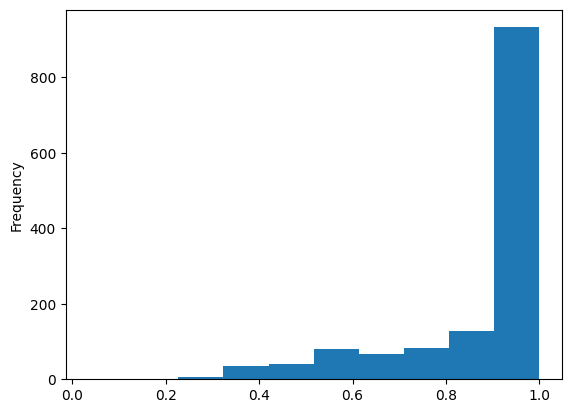

In [ ]:
MetricDF['Overall_Similarity'].plot.hist()
plt.show()

WOW! Great variation!  Let's normalize it just to pump it a bit.

In [ ]:
PercentGroup = MetricDF.Overall_Similarity.apply (lambda 
                                              x : 90 if (x>=90) 
                                              else (80 if (x>=80 and x<90)
                                                    else (70 if (x>=70 and x<80) 
                                                          else (60 if (x>=60 and x<70) 
                                                                else (50 if (x>=50 and x<60) 
                                                                      else (40 if (x>=40 and x<50) 
                                                                            else (30 if (x>=30 and x<40) 
                                                                                  else (20 if (x>=20 and x<30) 
                                                                                        else (10 if (x>=10 and x<20) 
                                                                                              else 0)  ) )  ) )) )))
                                              
                                               

In [ ]:
MetricDF['PercentRangeGroup'] = PercentGroup

In [ ]:
#MetricDF = MetricDF.drop(columns='pair')

In [ ]:
# def countryCodeConversion()

iCA = MetricDF['country_code_alpha2_A']
iCB = MetricDF['country_code_alpha2_B']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


a3A = [countries.get(country, 'Unknown code') for country in iCA]
a3B = [countries.get(country, 'Unknown code') for country in iCB]

In [ ]:
MetricDF['country_code_alpha3_A'] = a3A
MetricDF['country_code_alpha3_B'] = a3B

In [ ]:
MetricDF.drop(columns=['country_code_alpha2_A','country_code_alpha2_B'],inplace=True)

In [ ]:
MetricDF.head()

,pair,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity,PercentRangeGroup,country_code_alpha3_A,country_code_alpha3_B
308,"(CO, PE)",0.998878,0.999969,0.999710,0.999294,0,COL,PER
434,"(FR, LU)",0.998524,0.999941,0.999442,0.998983,0,FRA,LUX
1188,"(SE, NO)",0.998203,0.999972,0.999736,0.998970,0,SWE,NOR
515,"(HU, MD)",0.998071,0.999923,0.999275,0.998673,0,HUN,MDA
807,"(LU, DK)",0.998202,0.999894,0.998990,0.998596,0,LUX,DNK


******************
#5 ***`GENERATING JSON`***
******************

*Dropping other columns for JSON conversion format compliance*

In [21]:
# Function to change country name to alpha_3 code

def change_code(input_countries):
  input_countries = input_countries.to_list()
  countries = {}
  for country in pycountry.countries:
    countries[country.name] = country.alpha_3
  codes = [countries.get(country, 'Unknown code') for country in input_countries]
  return codes

In [ ]:
MetricDFJSON = MetricDF[['country_code_alpha3_A','country_code_alpha3_B','Overall_Similarity']]

In [ ]:
MetricDFJSON.head()

,country_code_alpha3_A,country_code_alpha3_B,Overall_Similarity
308,COL,PER,0.999294
434,FRA,LUX,0.998983
1188,SWE,NOR,0.998970
515,HUN,MDA,0.998673
807,LUX,DNK,0.998596


In [ ]:
pairs_of_similarities = {}
for _, row in MetricDFJSON.iterrows():
    country_pair = row.values[0] +'->'+ row.values[1]
    pairs_of_similarities[country_pair] = row.values[2]*100

In [ ]:
output_json = json.dumps(pairs_of_similarities)
output_json

In [ ]:
with open('data.json', 'w') as outfile:
    json.dump(output_json, outfile)

****************
# ***`6. Verifying results from 4 and 5`***

## 6a. Verifying results from 4 and 5

Why are there NA results for Greece and South Africa when data is present

In [ ]:
# iclabcombined[(iclabcombined['country']=='GR')&(iclabcombined['censored_updated']==True)]['site'].unique()

In [ ]:
# iclabcombined[(iclabcombined['country']=='ZA')&(iclabcombined['censored_updated']==True)]['site'].unique()

In [ ]:
# display(iclabcombined[(iclabcombined['country']=='GR')&(iclabcombined['censored_updated']==True)]['category'].unique())
# display(iclabcombined[(iclabcombined['country']=='ZA')&(iclabcombined['censored_updated']==True)]['category'].unique())

The NA results seem to be on account of dns being the column and values being zero for DNS in case of Greece

## 6b. Testing for different columns

In [ ]:
iclabcombined.isnull().sum(axis = 0)

server_t                   0
country                    0
schedule_name              0
url                        0
dns                 27829396
dns_reason          35216027
dns_all             13600017
dns_reason_all      37719857
http_status          2125476
block                2125476
body_len             2125476
http_reason          5185276
packet_updated      46636786
packet_reason       46636786
censored_updated           0
site                       0
category                   0
dtype: int64

In [ ]:
dummy_column_for_counting1 = 'block'

def as_single_column1 (df):
    return df[[dummy_column_for_counting1]]

def proportion1 (row):
    blocked = row[dummy_column_for_counting1+'_blocked']
    total = row[dummy_column_for_counting1+'_total']
    return blocked / total


blocking_proporitons1 =\
as_single_column1(total_blocked_observations_by_country)\
    .merge(as_single_column1(total_observations_by_country),
           on='country', suffixes=('_blocked', '_total'))\
    .apply(proportion1, axis=1)

In [ ]:
def get_proportion1 (cc2):
    # try to retrieve it
    try:
        return blocking_proporitons1[cc2]
    # if we don't have data on it
    except KeyError:
        # treat it as 0
        return 0

def compute_similarity1(proportion1, proportion2):
    # keep it simple....
    # minimum and maximum values will still be 0 and 1, since we're dealing with proportions.
    return 1 - abs(proportion1 - proportion2)

CountSimilarity1 = []
for item in pairs:
    (country1, country2) = item
    similarity1 = compute_similarity1(get_proportion1(country1), get_proportion1(country2))
    CountSimilarity1.append((item, similarity1))

In [ ]:
blocking_proportion_similarities1 =\
pd.DataFrame(CountSimilarity1, columns=[
    'pair',
    'proportion-similarity'
])
blocking_proportion_similarities1

,pair,proportion-similarity
0,"(AD, AT)",0.999677
1,"(AD, BE)",0.999441
2,"(AD, BR)",0.998499
3,"(AD, CA)",0.999493
4,"(AD, CR)",0.999595
...,...,...
1480,"(ZA, SG)",0.999847
1481,"(ZA, SK)",0.999613
1482,"(ZA, TR)",0.978443
1483,"(ZA, TW)",0.997163


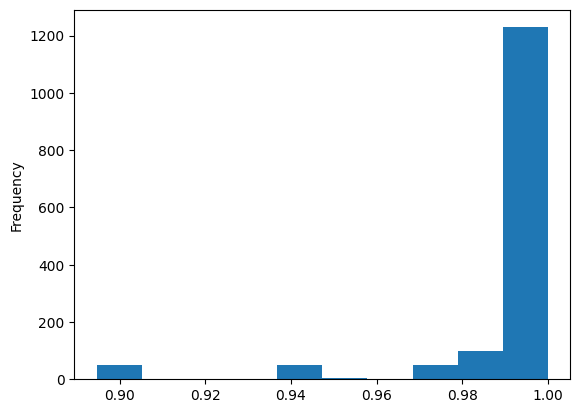

In [ ]:
blocking_proportion_similarities1['proportion-similarity'].plot.hist()
plt.show()

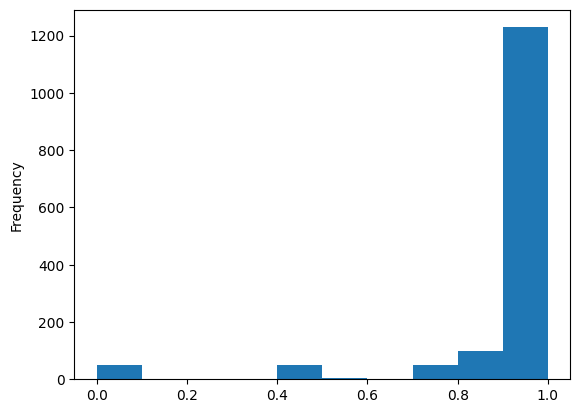

In [ ]:
def min_max_norm(series):
    return (series-series.min())/(series.max()-series.min())

blocking_proportion_similarities1['proportion-similarity-normalized'] = \
    min_max_norm(blocking_proportion_similarities1['proportion-similarity'])
blocking_proportion_similarities1['proportion-similarity-normalized'].plot.hist()

plt.show()

In [ ]:
MetricDF1 = pd.merge(simMetricVals,blocking_proportion_similarities1,on='pair',how='outer')
MetricDF1 = MetricDF1.rename(columns={
    'similarity':'Censored_Category_Similarity',
    'proportion-similarity-normalized':'Blocking_Proportion_Similarity',
})
MetricDF1['Overall_Similarity'] = (MetricDF1['Censored_Category_Similarity']+ MetricDF1['Blocking_Proportion_Similarity'])/2
MetricDF1 = MetricDF1.sort_values(by='Overall_Similarity',ascending=False)
MetricDF1

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity
961,"(NO, DK)",NO,DK,99.921272,0.999939,0.999424,50.460348
783,"(LT, NZ)",LT,NZ,99.906682,0.999900,0.999054,50.452868
926,"(NL, IL)",NL,IL,99.905538,0.999800,0.998099,50.451819
308,"(CO, PE)",CO,PE,99.887805,0.999957,0.999596,50.443700
377,"(ES, MD)",ES,MD,99.887884,0.999470,0.994966,50.441425
...,...,...,...,...,...,...,...
1227,"(SG, VE)",SG,VE,3.475451,0.997398,0.975288,2.225370
135,"(BG, VE)",BG,VE,3.224529,0.997901,0.980061,2.102295
1400,"(VE, CR)",VE,CR,2.410872,0.997508,0.976333,1.693602
271,"(CN, VE)",CN,VE,2.393743,0.992320,0.927041,1.660392


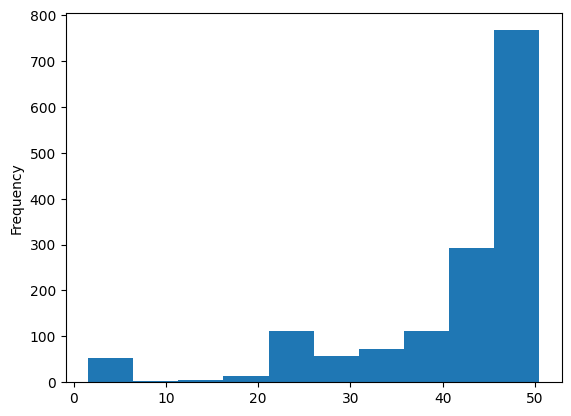

In [ ]:
MetricDF1['Overall_Similarity'].plot.hist()
plt.show()

****************
# 7. ***`HYPOTHESIS TESTING`***
****************

## Importing the Data

Importing the METRICDFJSON DataFrame

In [16]:
#MetricDFJSON.to_pickle("MetricDFJSON.pkl")
MetricDFJSON = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/MetricDFJSON.pkl")
MetricDFJSON = MetricDFJSON.dropna()
MetricDFJSON.shape

(1378, 3)

Importing non-Internet proxy data files

In [35]:
#Reading the NATO data
NATO = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/NATO.pkl")
NATO.shape

(29, 2)

In [22]:
#Prepping the WEF Data
WEF = pd.read_csv("../data/iclabcombined_and_hypothesis_data/WEFCompIndex.csv",index_col=0)
WEF['code'] = change_code(WEF['Country'])
missCodes =['TWN','KOR','IRL','CZE','RUS','BRN','VNM','GEO','MDA','IRN','BOL','Unknown code','Unknown code','TZA','CIV','GMB','VEN','COD']
missIdxs = WEF[WEF['code']=='Unknown code'].index

for i in range(len(missIdxs)):
  WEF.at[missIdxs[i],'code']= missCodes[i]

WEF = WEF[['code','scores']]

#Reading the WEF Data
WEF.to_pickle("WEF.pkl")
WEF = pd.read_pickle("WEF.pkl")

In [27]:
#Prepping the Commonwealth Data
# Commonwealth = pd.read_csv("../data/iclabcombined_and_hypothesis_data/CWdata.csv")
# code = change_code(Commonwealth['COUNTRY'])
# Commonwealth['code'] = code
# Commonwealth.at[6,'code']= 'BRN'
# Commonwealth.at[11,'code']= 'GMB'
# Commonwealth.at[31,'code']= 'CYP'
# Commonwealth.at[50,'code']= 'TZA'
# Commonwealth = Commonwealth[Commonwealth['code']!='Unknown code']

# #Reading the Commonwealth Data
# Commonwealth.to_pickle("../data/iclabcombined_and_hypothesis_data/Commonwealth.pkl")
Commonwealth = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/Commonwealth.pkl")
Commonwealth.shape

(49, 2)

In [32]:
# #Prepping the Media Freedom Data
# MediaDF = pd.read_csv('../data/iclabcombined_and_hypothesis_data/PressFreedomIndex.csv').loc[:,['ISO','Score 2019','Rank 2019']].sort_values(by='Rank 2019',ascending=True).set_index("Rank 2019")
# MediaDF['Score 2019'] = MediaDF['Score 2019'].apply(lambda x : x.replace(',','.') )
# MediaDF['Score 2019'] = MediaDF['Score 2019'].astype(float)
# MediaDF.rename(columns={'ISO':'code','Score 2019':'scores'},inplace=True)
# MediaDF['scores'] = 100 - MediaDF['scores']

# #Reading the Media Freedom Data
# MediaDF.to_pickle("../data/iclabcombined_and_hypothesis_data/MediaDF.pkl")
MediaDF = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/MediaDF.pkl")
MediaDF.shape

(180, 2)

In [33]:
# #Prepping the QNI Data
# QNI = pd.read_csv('QNI.csv').sort_values(by='Total',ascending=False).dropna()
# CCode = change_code(QNI['Country'])
# QNI['code']= CCode
# QNI = QNI[['code','Total']].rename(columns={'Total':'scores'})

# #Reading the Media Freedom Data
# QNI.to_pickle("../data/iclabcombined_and_hypothesis_data/QNI.pkl")
QNI = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/QNI.pkl")
QNI.shape

(209, 2)

In [34]:
# #Prepping the FIW (Freedom in the World) Data
# Freedom = pd.read_csv('../data/iclabcombined_and_hypothesis_data/FH2018.csv')
# code = change_code(Freedom['Country/Territory'])
# Freedom['code'] = code
# Freedom = Freedom[['code','Total']].rename(columns={'Total':'scores'})
# Freedom = Freedom.sort_values(by='scores',ascending=False)
# Freedom = Freedom[Freedom['code']!='Unknown code']

# #Reading the FIW Data
# Freedom.to_pickle("../data/iclabcombined_and_hypothesis_data/Freedom.pkl")
Freedom = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/Freedom.pkl")
Freedom.shape

(174, 2)

## General purpose functions to test our hypothesis'.

We will be using the Mann Whitney U test to determine if two groups are similar to each other or not. This is a non-parametric test used for samples of at least size 20 when the samples dont originate from normal distributions. To learn more refer the link below:

[MannWhitneyUTest](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [168]:
def correlation (df):
    blocking_sims = []
    wef_sims = []
    
    def get_value (country):
        return df[df['code']==country].scores.values[0]
    
    for _, row in MetricDFJSON.iterrows():
        country1 = row['country_code_alpha3_A']
        country2 = row['country_code_alpha3_B']
        try:
            country1_wef = get_value(country1)
        except:
            pass
        try:
            country2_wef = get_value(country2)
        except:
            pass
        sim = 100 - abs(country1_wef - country2_wef)
        wef_sim = sim/100
        wef_sims.append(wef_sim)
        blocking_sim = row['Overall_Similarity']
        blocking_sims.append(blocking_sim)
        
    deg_freedom = len(blocking_sims)-2
    test = scipy.stats.pearsonr(blocking_sims, wef_sims)
    
    return {
        'test': test, 
        'degrees of freedom': deg_freedom,
    }

In [169]:
def Hypo_Test_Groups(df):

  '''
  Parameters:
  Dataframe of non-interent proxy

  Used when our proxy measure buckets countries based on their presence or absence in a group e.g. NATO or CommonWealth
  Creates 2 buckets
  One for an edge where both vertices are countries that are members of a given group
  Another for an edge where one vertice belongs to member country and another to a non-member country.

  Returns:
  p value for the MannWhitneyU test run on these two buckets
  variances for these two buckets
  '''

  #List of countries which are in the Affinity group like NATO or Commonwealth
  AffinityGroup = df['code'].to_list()
  
  #Determining indexes of our two buckets
  #One bucket is for similar edges i.e. both countries are members of a group
  #The other bucket is for dissimilar edges i.e. while one country is a group member the other is not
  allIndex = MetricDFJSON.index.to_list()
  nonMembersIndex =  (MetricDFJSON[~((MetricDFJSON['country_code_alpha3_A'].isin(AffinityGroup)) | (MetricDFJSON['country_code_alpha3_B'].isin(AffinityGroup)))]).index.to_list()
  bothMembersIndex = (MetricDFJSON[(MetricDFJSON['country_code_alpha3_A'].isin(AffinityGroup)) & (MetricDFJSON['country_code_alpha3_B'].isin(AffinityGroup))]).index.to_list()
  oneMemberIndex =  [idx for idx in allIndex if idx not in (nonMembersIndex+bothMembersIndex)]

  #Similarity scores for the two buckets
  Member2MemberScores = MetricDFJSON.loc[bothMembersIndex]['Overall_Similarity'].to_list()
  Member2NonMemberScores = MetricDFJSON.loc[oneMemberIndex]['Overall_Similarity'].to_list()

  #MannWhitneyUTest
  tScore,p = scipy.stats.mannwhitneyu(Member2MemberScores,Member2NonMemberScores,use_continuity=True,alternative='greater')
  testResults = {'test score':tScore, 'p Value':p}

  variancesDict = {
      'Varinace between Similiar Edges' : statistics.variance(Member2MemberScores),
      'Variance between Dissimilar Edges' : statistics.variance(Member2NonMemberScores),
  }

  mediansDict = {
      'Median of hyp. greater group': np.median(Member2MemberScores),
      'Median of hyp. less group': np.median(Member2NonMemberScores),
  }

  return testResults, variancesDict, mediansDict

## 7a. Military Alliance (NATO Members)

The North Atlantic Treaty Organization, also called the North Atlantic Alliance, is an intergovernmental military alliance between 30 North American and European countries

Learn More: 

[About NATO](https://en.wikipedia.org/wiki/Member_states_of_NATO)

In [170]:
#Checking the Data
NATO.head(3)

,CNTRY_NAME,code
0,Albania,ALB
1,Belgium,BEL
2,Bulgaria,BGR


Essentially testing - Countries are more similar to each other in Internet Censorship when they are NATO members as opposed to when one of them is a NATO member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of NATO AND country pairs wherein one country is a member of NATO while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of NATO IS GREATER THAN country pairs wherein one country is a member of NATO while the other isnt. 


In [171]:
Hypo_Test_Groups(NATO)

({'test score': 79556.0, 'p Value': 3.87518494655817e-19},
 {'Varinace between Similiar Edges': 0.012768973625993559,
  'Variance between Dissimilar Edges': 0.026379295854797202},
 {'Median of hyp. greater group': 0.9908185531792778,
  'Median of hyp. less group': 0.9553708687940732})

Since the above p value is lesser than threshold(0.5), we can reject H0

Hence we can conclude that countries which are memebrs of NATO are more similar to each other than to countries which arent members of NATO

As expected non-members states have much higher variance than member states

## 7b. Economy (WEF Competitiveness Index)

The World Economic Forums Global Competitiveness Index measures the set of institutions, policies, and factors that set the sustainable current and medium-term levels of economic prosperity. The Global Competitiveness Index's annual reports are somewhat similar to the Ease of Doing Business Index.

Learn More:

[WEF 2019 Report](https://en.wikipedia.org/wiki/Global_Competitiveness_Report)

In [172]:
# Reading the Data
WEF.head(3)

,code,scores,Index
0,SGP,84.8,High
1,USA,83.7,High
2,HKG,83.1,High


### Test 1: Correlation
We compute simliarities between WEF scores across country pairs. 

In [173]:
correlation(WEF)

{'test': (0.1532195406499631, 1.0883644659921674e-08),
 'degrees of freedom': 1376}

We find similarities in WEF scores to be slightly positively correlated with similarities in website blocking, r(1376) = 0.15, p<0.001. 

## European Economic Area (EEA) 


Austria, Belgium, Bulgaria, Croatia, Republic of Cyprus, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Iceland, Norway, Sweden.



In [174]:
EEA_country_names = [
 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Iceland', 'Norway', 'Sweden', 'Liechtenstein', 'Norway', 'Switzerland',   
]

ccs = pd.read_csv('../local_country_variables/countries_codes_and_coordinates.csv')

eea = []
for name in EEA_country_names:
    try:
        alpha3cc = ccs[ccs['Country'] == name]['Alpha-3 code'].values[0][2:-1]
    except:
        pass
    eea.append([name, alpha3cc])

EEA = pd.DataFrame(eea, columns=['CNTRY_NAME', 'code'])

In [175]:
Hypo_Test_Groups(EEA)

({'test score': 90590.0, 'p Value': 4.2886529811028635e-21},
 {'Varinace between Similiar Edges': 0.0010116765775590615,
  'Variance between Dissimilar Edges': 0.025814691328673017},
 {'Median of hyp. greater group': 0.9889461276295837,
  'Median of hyp. less group': 0.9552646623894848})

## 7c. Cultural affinity (Commonwealth Members)

The Commonwealth of Nations is a political association of 54 member states, nearly all former territories of the British Empire. Member states have no legal obligations to one another, but are connected through their use of the English language and historical ties.

Learn More:
[Commonwealth of Nations](https://en.wikipedia.org/wiki/Commonwealth_of_Nations)

In [183]:
#Reading the Data
Commonwealth.head(3)

,COUNTRY,code
0,Antigua and Barbuda,ATG
1,Australia,AUS
2,Bangladesh,BGD


Essentially testing - Countries are more similar to each other in Internet Censorship when they are culturally aligned (e.g. both are Commonwealth nations) as opposed to when one of them is a Commonwealth member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of Commonwealth AND country pairs wherein one country is a member of Commonwealth while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of Commonwealth IS GREATER THAN country pairs wherein one country is a member of Commonwealth while the other isnt. 


In [184]:
Hypo_Test_Groups(Commonwealth)

({'test score': 9393.0, 'p Value': 0.6264448631342487},
 {'Varinace between Similiar Edges': 0.03171062310318558,
  'Variance between Dissimilar Edges': 0.02995818757560687},
 {'Median of hyp. greater group': 0.9466965491621719,
  'Median of hyp. less group': 0.9540215084273962})

Since the above p value is greater than threshold(0.5), we CAN NOT reject H0

Hence we CAN NOT SAY that countries which are memebrs of commonwealth are more similar to each other than to countries which arent members of COMMONWEALTH.

Chances are a country could be as similar to a member of commonwealth in terms of its internet censorship as it could be to a non member

The variance calculated for these two buckets also demonstrates the same

## 7d. Media Freedom (World Freedom of Press Index)

The WORLD PRESS FREEDOM INDEX by Reporters Without Borders ranks 180 countries and regions according to the level of freedom available to journalists. It is a snapshot of the media freedom situation based on an evaluation of pluralism, independence of the media, quality of legislative framework and safety of journalists in each country and region.

Learn More:

Reporters Without Borders Report [2019 Ranking](https://rsf.org/en/ranking/2019)



In [178]:
#Reading the Data
MediaDF.head(3)

,code,scores
Rank 2019,,
1,NOR,92.18
2,FIN,92.10
3,SWE,91.69


In [179]:
correlation(MediaDF)

{'test': (0.40284008922040404, 6.573405995296292e-55),
 'degrees of freedom': 1376}

We find a moderate positive correlation between blocking similarity and media freedom, r(1376 )= 0.40, p<0.001.

Since the above p value is lesser than threshold(0.5), we can reject H0


Hence we can conclude that country which are having high press Freedom  are more similar in internet censorship to countries where there is also high press Freedom THAN to countries which are having lesser press freedom

The difference in variation of their similarity scores is noteworthy. The variance of similarity scores for edges where both countries have high press freedom is 10 times lesser than variance in similarity scores for edges wherein only one country has high press freedom while the other has low press freedom

## 7e. Quality of Nationality (QNI Index)

The Quality of Nationality Index (QNI) ranks the objective quality of nationalities worldwide. It explores three internal factors (economic strength, human development, and peace and stability) and four external factors (diversity and weight of travel freedom and diversity and weight of settlement freedom) which are used to measure the value of virtually all nationalities worldwide

Learn More:

[QNI website](https://www.nationalityindex.com/)

[Wiki Page](https://en.wikipedia.org/wiki/The_Quality_of_Nationality_Index)

In [180]:
#Reading the Data
QNI.head(3)

,code,scores
60,FRA,83.46
127,NLD,82.82
64,DEU,82.75


In [182]:
correlation(QNI)

{'test': (0.08112200732025271, 0.0025816851857823515),
 'degrees of freedom': 1376}

Since the above p value is lesser than threshold(0.5), we can reject H0

Hence we can conclude that country which are having high quality of overall living  are more similar in internet censorship to countries where there is high quality of overall living THAN to countries which are having low quality of overall living 

The difference in variation of their similarity scores is noteworthy. The variance of similarity scores for edges where both countries have high QNI Index is almost 8 times lesser than variance in similarity scores for edges wherein only one country has high QNI index  while the other has low QNI index 

## 7f. Civil Rights and Freedom  (Freedom in the World Index)

Freedom in the World is Freedom House's flagship annual report, assessing the condition of political rights and civil liberties around the world. For each country and territory, Freedom in the World analyzes the electoral process, political pluralism and participation, the functioning of the government, freedom of expression and of belief, associational and organizational rights, the rule of law, and personal autonomy and individual rights.

Learn More:

[FIW 2018 Report](https://freedomhouse.org/sites/default/files/2020-02/FreedomintheWorld2018COMPLETEBOOK.pdf)

In [24]:
#Reading the Data
Freedom.head(3)

,code,scores
135,NOR,100
61,FIN,100
176,SWE,100


In [167]:
correlation(Freedom)

{'test': (0.44549826210629173, 3.799586314786976e-68),
 'degrees of freedom': 1376}

We find a moderate positive correlation between World Press Freedom ranking similarity and Internet blocking similarity, r(1376) = 0.45, p<0.001.